# Курсовой проект "Python для Data Science"
## Павел Белов

In [1]:
import numpy as np
import pandas as pd
import pickle
np.set_printoptions(precision=2)
pd.set_option('display.max_columns', 50)


from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d.axes3d import Axes3D

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse

import random
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn')

## Опишем пути.

In [2]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'
OUTPUT_FILENAME = "Pavel_Belov_predictions.csv"

## Импортируем данные.

In [3]:
df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


## При предварительном анализе обратил внимание на след. факты:

+ Значения цены не повторяются. Нет характерных "психологических" отметок, вроде 199 тысяч долларов, вероятно датасет сгенерирован и гипотезы "из реальной жизни" к нему примерять не стоит.

+ Бинарные признаки представлены буквами, и требуют перевода в 0 и 1.

+ DistrictId представлен числом, которое не несет смысла, а кодирует название округа. Возможно стоит заменить их dummy признаками, однако это сильно разредит данные.

+ LifeSquare и Healthcare_1 имеют множество пропусков и требуют заполнения.

+ Присутствует анамалия 1977 года - это явно ошибка в данных, которую стоит учесть.



### Распределение самых частых годов постройки видно два пика строительства и феномен 77 года

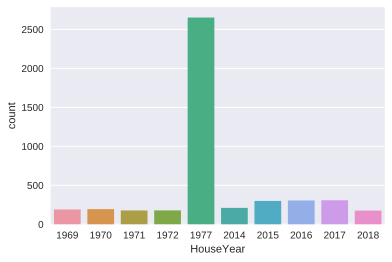

In [4]:
sns.countplot(df[df['HouseYear'].isin(df['HouseYear'].value_counts().head(10).index)]['HouseYear']);

### Построим тепловую диаграмму корелляций

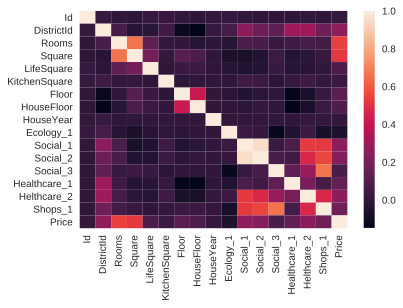

In [5]:
sns.heatmap(df.corr());

### Social_1 и Social_2 кореллируют Social_2 кореллирует с Shops_1, а так же с первыми двумя Social.

In [6]:
cor_feat =['Social_1' ,'Social_2', 'Social_3', 'Shops_1']

In [7]:
# Тяжелый график, закоментировал чтобы компьютер не тормозил.
# sns.pairplot(df[cor_feat]);

## Предварительная подготовка данных 

Исправление АВ признаков

In [8]:
def AB_to_int(ser):
    if ser == 'A':
        return 1
    elif ser == 'B':
        return 0
    else:
        return ser

In [ ]:
df['Ecology_2'] = df['Ecology_2'].apply(AB_to_int)
df['Ecology_3'] = df['Ecology_3'].apply(AB_to_int)
df['Shops_2'] = df['Shops_2'].apply(AB_to_int)
test_df['Ecology_2'] = test_df['Ecology_2'].apply(AB_to_int)
test_df['Ecology_3'] = test_df['Ecology_3'].apply(AB_to_int)
test_df['Shops_2'] = test_df['Shops_2'].apply(AB_to_int)
set(test_df['Shops_2'])

{0, 1}

DistrictId заполнен цифрами, однако данные не по порядку, а значение цифры не несет математического смысла, а лишь кодирует район. Однако предположительно, признак важен, а районы делятся на "дорогие" и "неблагополучные". Стоит изучить этот признак подробнее.

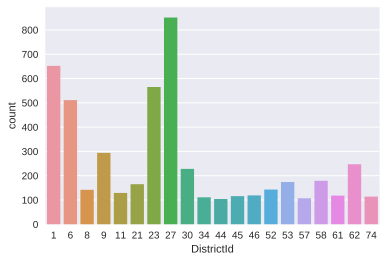

In [ ]:
sns.countplot(df[df['DistrictId'].isin((df['DistrictId'].value_counts().head(20)).index)]['DistrictId']);

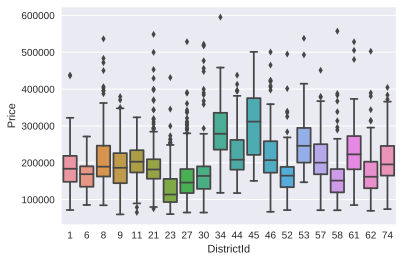

In [ ]:
sns.boxplot(x=(df[df['DistrictId'].isin((df['DistrictId'].value_counts().head(20)).index)]['DistrictId']), y='Price', data=df);

Сопоставляя графики видно, что округа 1, 6, 23, 27 чаще встречаются в выборке, и для этих районов характерно дешевое жилье. А, например, 34 и 45 округа более дорогие, при этом зависимость цены от района видна четко, но с номером корелляции нет.
Видится два способа использовать эти данные - либо заменить эту колонку dummy признаками. Либо создать словарь средних значений цены для каждого района, и на основе его сгенерировать новый признак - Mean_Distr_Price, который заменит DistrictId и уже будет нести осмысленную информацию. К этому вопросу стоит вернуться при тюнинге модели.


Заменяю DistrictId на медианные цены по округам.

In [ ]:
median_dict_price = {}
for look, sub_df in df.groupby('DistrictId'):
    median_dict_price[look] = sub_df['Price'].median()

In [ ]:
df['DistrictId_median_price'] = df['DistrictId'].map(median_dict_price)

In [ ]:
test_df['DistrictId_median_price'] = test_df['DistrictId'].map(median_dict_price)

In [ ]:
# удаление признака
df.drop('DistrictId', axis=1).head()


,Id,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictId_median_price
0,14038,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,0,0,33,7976,5,NaN,0,11,0,184966.930730,203602.408898
1,15053,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,0,0,46,10309,1,240.0,1,16,0,300009.450063,210694.850106
2,4765,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,0,0,34,7759,0,229.0,1,3,0,220925.908524,245978.794474
3,5809,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,0,0,23,5735,3,1084.0,0,5,0,175616.227217,151557.904767
4,10783,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,0,0,35,5776,1,2078.0,2,4,0,150226.531644,178829.166450


In [ ]:
test_df.drop('DistrictId', axis=1).head()

,Id,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,DistrictId_median_price
0,725,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,0,0,11,2748,1,NaN,0,0,0,151557.904767
1,15856,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,0,0,6,1437,3,NaN,0,2,0,195610.960042
2,5480,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,0,0,30,7538,87,4702.0,5,5,0,526438.458919
3,15664,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,0,0,23,4583,3,NaN,3,3,0,196429.659238
4,14275,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,0,0,2,629,1,NaN,0,0,1,146171.433190


In [ ]:
test_df['DistrictId_median_price'].isna().sum(axis=0)

8

В тестовой части присутствует округ, домов из которого не было в тренировочной. Заменим медианным значением по выборке.

In [ ]:

test_df.loc[test_df['DistrictId_median_price'].isnull(), 'DistrictId_median_price'] = df['Price'].median()

Признак Healthcare_1 имеет множество пропусков. Взглянем на распределение 


In [ ]:
df['Healthcare_1'].hist();

Распределение асимметрично, пока заполним его медианными значениями. 
Так же считаю полезным завести бинарный признак (для Healthcare_1 и других признаков, которые буду править, оригинальное значение признака, или оно было сгенерировано, чтобы модель при обучении могла ориентироваться и на это.

In [ ]:
def fix_feature(dataset, feature, is_gen_feature):
#     dataset[is_gen_feature] = 0
#     dataset.loc[dataset[feature].isnull(), is_gen_feature] = 1
    dataset.loc[dataset[feature].isnull(), feature] = dataset[feature].median()
    return dataset

In [ ]:
# df = fix_feature(df, 'Healthcare_1', 'is_gen_Healthcare_1')
# test_df = fix_feature(test_df, 'Healthcare_1', 'is_gen_Healthcare_1')

Аналогично для признака LifeSquare, при этом понятно, что LifeSquare не может быть больше Square, поэтому простая замена медианой видится не лучшим вариантом. посмотрим, как эти признаки кореллируют.


In [ ]:
plt.scatter(df['LifeSquare'], df['Square']);

Видны явно не корректные значения, где площадь меньше жилой площади. В основном это "погрешность измерения", но есть и явные выбросы. Сделаем, чтобы жилая площадь не превышала общую.

Теперь можно заполнить пропуски. Учитывая, что площадь кореллирует с жилой площадью, можно высчитать недостающие значения исходя из общей площади.

In [ ]:
df[df['LifeSquare'] > df['Square']].head()

In [ ]:
k_square = df['LifeSquare'].mean() / df['Square'].mean()
def fix_square(dataset):
#     dataset['is_gen_LifeSquare'] = 0
#     dataset.loc[dataset['LifeSquare'].isnull(), 'is_gen_LifeSquare'] = 1
    dataset.loc[(dataset['LifeSquare'] > dataset['Square']), 'LifeSquare'] = dataset['Square']    
    dataset.loc[(dataset['LifeSquare'].isnull()), 'LifeSquare'] = dataset['Square'] * k_square
    return dataset

In [ ]:
df = fix_square(df)
test_df = fix_square(test_df)


In [ ]:
plt.scatter(df['LifeSquare'], df['Square']);

Теперь на графике видна корелляция признаков, однако существуют здания где жилая площадь много меньше общей. Такое возможно - нежилые помещения. 

Создам отдельный признак для 1977 года

In [ ]:
df.head()

In [ ]:
# df['Is_1977'] = (df['HouseYear'] == 1977).astype('int32')
# test_df['Is_1977'] = (test_df['HouseYear'] == 1977).astype('int32')

#### Разобьем тестовую выборку на части и обучим предсказывать Healthcare_1


In [ ]:
test_healthcare = df.loc[df['Healthcare_1'].isnull()]
test_df_healthcare = test_df.loc[test_df['Healthcare_1'].isnull()].drop(columns=["Healthcare_1"])


In [ ]:
train_healthcare = df.dropna()

В тестовой выборке цена неизвестна, поэтому нельзя использовать ее для предсказания Healthcare_1

In [ ]:
test_healthcare = test_healthcare.drop(columns=["Price"])
train_healthcare = train_healthcare.drop(columns=["Price"])

In [ ]:
y = train_healthcare["Healthcare_1"]
X = train_healthcare.drop(columns=["Healthcare_1"])
 


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

Подбираю параметры модель предсказания Healthcare_1

In [ ]:
r2_train = []
r2_test = []
len_trees = 15
for i in range(2, len_trees):
    gb_model = RandomForestClassifier(max_depth=i, random_state = 1, n_estimators = 100)
    gb_model.fit(X_train, y_train)
    pred_train = gb_model.predict(X_train)
    pred_test = gb_model.predict(X_test)
    r2_train.append(r2(y_train, pred_train))
    r2_test.append(r2(y_test, pred_test));

In [ ]:
plt.scatter(list(range(2, len_trees)), r2_train)
plt.scatter(list(range(2, len_trees)), r2_test);

Обучаю модель на тестовой выборке.

In [ ]:
gb_model = RandomForestClassifier(max_depth=14, random_state = 1, )
gb_model.fit(X_train, y_train)
pred_train = gb_model.predict(X_train)
pred_test = gb_model.predict(X_test)

In [ ]:
test_df_healthcare = test_df.loc[test_df['Healthcare_1'].isnull()].drop(columns=["Healthcare_1"])
test_df_healthcare.head()

In [ ]:
pred_test = pd.Series(gb_model.predict(X_test))


In [ ]:
r2(y_test, pred_test)


In [ ]:
pred_healt_df = pd.Series(gb_model.predict(df.drop(columns=["Healthcare_1", "Price"])), name='Healthcare_1')
pred_healt_test_df = pd.Series(gb_model.predict(test_df.drop(columns=["Healthcare_1"])), name='Healthcare_1')


In [ ]:
# df = df.drop(columns=['Healthcare_1'])
df['Healthcare_1_p'] = pred_healt_df
# test_df = test_df.drop(columns=['Healthcare_1'])
test_df['Healthcare_1_p'] = pred_healt_test_df


In [ ]:
def rule(x):
    if np.isnan(x['Healthcare_1']):
         return x['Healthcare_1_p']
    else:
         return x['Healthcare_1']

df['Healthcare_1'] = df.apply(lambda x: rule(x), axis = 1)
df = df.drop(columns=["Healthcare_1_p"])

test_df['Healthcare_1'] = test_df.apply(lambda x: rule(x), axis = 1)


In [ ]:
test_df = test_df.drop(columns=["Healthcare_1_p"])
# test_df = test_df.drop(columns=["Price"])

df.head()

## Этажи

In [ ]:
# df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = df['HouseFloor'].median()

In [ ]:
# floor_outliers = df[df['Floor'] > df['HouseFloor']].index

# df.loc[floor_outliers, 'Floor'] = df.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))

# Удаление лишних признаков

In [ ]:
test_df_id = test_df['Id']

In [ ]:
df.drop(columns=['Ecology_2', 'Ecology_3', 'Shops_2', 'DistrictId', 'Helthcare_2', 'Shops_1', 
                      'Ecology_1', 'Id'], inplace=True)
df.head()

In [ ]:
test_df.drop(columns=['Ecology_2', 'Ecology_3', 'Shops_2', 'DistrictId', 'Helthcare_2', 'Shops_1', 
                      'Ecology_1', 'Id'], inplace=True)

## Построение модели

Разобьем тренировочный датасет на выборки

In [ ]:
y = df["Price"]
X = df.drop(columns=["Price"])

In [ ]:
df.head()


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

## Случайный лес
Подберем глубину деревьев для случайного леса.

In [ ]:
r2_train = []
r2_test = []
len_trees = 25
for i in range(5, len_trees):
    rf_model = RandomForestRegressor(max_depth=i, random_state = 1001)
    rf_model.fit(X_train, y_train)
    pred_train = rf_model.predict(X_train)
    pred_test = rf_model.predict(X_test)
    r2_train.append(r2(y_train, pred_train))
    r2_test.append(r2(y_test, pred_test));


In [ ]:
plt.scatter(list(range(5, len_trees)), r2_train)
plt.scatter(list(range(5, len_trees)), r2_test);

# Поменяв random_state для разбиения выборки несколько раз, убедился, что глубина 10 является оптимальной. 
Строим лес с такой глубиной

In [ ]:

rf_model = RandomForestRegressor(max_depth=10, random_state = 1001)
rf_model.fit(X_train, y_train)
pred_train = rf_model.predict(X_train)
pred_test = rf_model.predict(X_test)

Делаем предсказание

In [ ]:
pred_real = rf_model.predict(test_df)

Рассчитываем R2

In [ ]:
r2(y_test, pred_test)

Важность признаков


In [ ]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

## Градиентный бустинг

In [ ]:
# r2_train = []
# r2_test = []
# len_trees = 20
# for i in range(2, len_trees):
#     gb_model = GradientBoostingRegressor(max_depth=i, random_state = 1, n_estimators = 100)
#     gb_model.fit(X_train, y_train)
#     pred_train = gb_model.predict(X_train)
#     pred_test = gb_model.predict(X_test)
#     r2_train.append(r2(y_train, pred_train))
#     r2_test.append(r2(y_test, pred_test));

In [ ]:
# plt.scatter(list(range(2, len_trees)), r2_train)
# plt.scatter(list(range(2, len_trees)), r2_test);

In [ ]:
# r2_train = []
# r2_test = []

# for i in range(3, df.shape[1], 5):
#     gb_model = GradientBoostingRegressor(max_depth=8, random_state = 1, max_features=i)
#     gb_model.fit(X_train, y_train)
#     pred_train = gb_model.predict(X_train)
#     pred_test = gb_model.predict(X_test)
#     r2_train.append(r2(y_train, pred_train))
#     r2_test.append(r2(y_test, pred_test));

In [ ]:
# plt.scatter(list(range(3, df.shape[1], 5)), r2_train)
# plt.scatter(list(range(3, df.shape[1], 5)), r2_test);

In [ ]:
# gb_model = GradientBoostingRegressor(max_depth=7, random_state = 1, n_estimators = 120, max_features=75 )
# gb_model.fit(X_train, y_train)
# pred_train = gb_model.predict(X_train)
# pred_test = gb_model.predict(X_test)

In [ ]:
# pred_real = rf_model.predict(test_df)

In [ ]:
# r2(y_test, pred_test)

## Перекрестная проверка

In [ ]:
cv_score = cross_val_score(rf_model, X, y, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=1001))
cv_score.mean()

## Обучаю модель на всей доступной выборке

In [ ]:
y_train = df['Price']
X_train = df.drop(columns=['Price'])

In [ ]:

rf_model = RandomForestRegressor(max_depth=12, random_state = 1001)
rf_model.fit(X_train, y_train)
pred_train = rf_model.predict(X_train)
pred_test = rf_model.predict(X_test)

In [ ]:
pred_real = rf_model.predict(test_df)

## Записываем предсказание в выходной файл

In [ ]:
pd.DataFrame({
    "id": test_df_id,
    "Price": pred_real
}).to_csv(OUTPUT_FILENAME, index=False)